In [1]:
!pip install pandas
!pip install tldextract
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 2.2 MB/s eta 0:00:00


In [2]:
# Imports
import pandas as pd
import re
import tldextract
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Read Data File
file_path = './malicious_html_enhanced.csv'

data = pd.read_csv(file_path)
data.shape

<ipython-input-3-51a12ae0a509>:4: DtypeWarning: Columns (2,4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


(651191, 11)

In [4]:
# Filter out inactive links
data = data[data['error'] == 'none']
data.shape

(145037, 11)

In [5]:
def categorize_type(type):
    if type in ['benign', 'defacement']:
        return 0 # SAFE
    else:
        return 1

# Apply the function to create a new column
data['safety'] = data['type'].apply(categorize_type)
data.head(n=10)

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,content_length,safety
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,26155,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,274145,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,20403,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,57282,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,201519,0
12,myspace.com/video/vid/30602581,benign,none,200,text/html,"{'Vary': 'Accept-Encoding', 'Set-Cookie': 'pla...",15,{'visit_id': <Morsel: visit_id=1c54019f-97c5-4...,2,1,89272,0
14,http://www.szabadmunkaero.hu/cimoldal.html?sta...,defacement,none,404,text/html,"{'Content-Type': 'text/html', 'Content-Length'...",4,{},0,0,341,0
17,nugget.ca/ArticleDisplay.aspx?archive=true&e=1...,benign,none,404,text/html,"{'Server': 'istio-envoy', 'Date': 'Thu, 02 May...",16,{},0,1,158730,0
18,uk.linkedin.com/pub/steve-rubenstein/8/718/755,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",19,{'fid': <Morsel: fid=AQFrvBx7TRPLMQAAAY87SBJeV...,4,1,287945,0
19,http://www.vnic.co/khach-hang.html,defacement,none,200,text/html,"{'Cache-Control': 'no-store, no-cache, must-re...",11,{'81f30cf708470b974874c8a96a6bcdb2': <Morsel: ...,1,0,41817,0


In [6]:
def get_length(url):
  return len(url)

data['length'] = data['url'].apply(get_length)
data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,content_length,safety,length
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,26155,0,31
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,274145,0,45
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,20403,0,46
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,57282,0,45
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,201519,0,62


In [7]:
special_chars = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',']

for special_char in special_chars:
  def get_count(url):
    return url.count(special_char)

  data[f'num_{special_char}'] = data['url'].apply(get_count)

data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_-,num_=,num_.,num_#,num_%,num_+,num_$,num_!,num_*,"num_,"
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,0,2,0,0,0,0,0,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,1,0,2,0,0,0,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,2,1,1,0,0,0,0,0,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,4,0,1,0,0,0,0,0,0,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,3,0,2,0,0,0,0,0,0,0


In [8]:
ip_pattern = (
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)'
    r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
    r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
    r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'
)

def has_ip_address(url):
    return int(re.search(ip_pattern, url, flags=re.I) is not None)

data['Has_IP'] = data['url'].apply(has_ip_address)
data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_=,num_.,num_#,num_%,num_+,num_$,num_!,num_*,"num_,",Has_IP
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,2,0,0,0,0,0,0,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,0,2,0,0,0,0,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,1,1,0,0,0,0,0,0,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,0,1,0,0,0,0,0,0,0,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,0,2,0,0,0,0,0,0,0,0


In [9]:
shortening_pattern = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                     r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                     r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                     r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                     r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                     r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                     r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                     r'tr\.im|link\.zip\.net'

def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

data['Is_Short'] = data['url'].apply(has_shortening_service)

data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_.,num_#,num_%,num_+,num_$,num_!,num_*,"num_,",Has_IP,Is_Short
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,2,0,0,0,0,0,0,0,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,2,0,0,0,0,0,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,1,0,0,0,0,0,0,0,0,1
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,1,0,0,0,0,0,0,0,0,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,2,0,0,0,0,0,0,0,0,0


In [10]:
def count_alpha_chars(string):
    return sum(1 for char in string if char.isalpha())

data['alpha'] = data['url'].apply(count_alpha_chars)

def count_numeric_chars(string):
    return sum(1 for char in string if char.isnumeric())

data['numeric'] = data['url'].apply(count_numeric_chars)

data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_%,num_+,num_$,num_!,num_*,"num_,",Has_IP,Is_Short,alpha,numeric
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,0,0,0,0,0,0,0,25,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,0,0,0,0,0,0,0,0,31,4
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,0,0,0,0,0,0,0,1,40,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,0,0,0,0,0,0,0,0,33,5
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,0,0,0,0,0,0,0,0,47,7


In [11]:
def has_https(url):
    return int("https" in url)

data['Has_HTTPS'] = data['url'].apply(has_https)

data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_+,num_$,num_!,num_*,"num_,",Has_IP,Is_Short,alpha,numeric,Has_HTTPS
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,0,0,0,0,0,0,25,1,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,0,0,0,0,0,0,0,31,4,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,0,0,0,0,0,0,1,40,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,0,0,0,0,0,0,0,33,5,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,0,0,0,0,0,0,0,47,7,0


In [12]:
# TLD processing - Avoided using as created too large one hot vector.
"""
tlds = {}
i = 0
with open('tlds.txt', 'r') as file:
    next(file)
    for line in file:
        tlds[line.strip().lower()] = i
        i += 1
"""

"""
def get_tld(url):
    extracted = tldextract.extract(url)
    tld = extracted.suffix.lower()
    return tld

data['TLD'] = data['url'].apply(get_tld)
data.head()



tld_dum = pd.get_dummies(data['TLD'])
data = pd.concat([data, tld_dum], axis=1)
"""

data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_+,num_$,num_!,num_*,"num_,",Has_IP,Is_Short,alpha,numeric,Has_HTTPS
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,0,0,0,0,0,0,25,1,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,0,0,0,0,0,0,0,31,4,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,0,0,0,0,0,0,1,40,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,0,0,0,0,0,0,0,33,5,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,0,0,0,0,0,0,0,47,7,0


In [13]:
def check_for_code(url):
    if 'javascript:' in url:
        return 1
    if re.search(r'<\s*script', url, re.IGNORECASE):
        return 1
    return 0

data['code'] = data['url'].apply(check_for_code)
data.head()



,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_$,num_!,num_*,"num_,",Has_IP,Is_Short,alpha,numeric,Has_HTTPS,code
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,0,0,0,0,0,25,1,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,0,0,0,0,0,0,31,4,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,0,0,0,0,0,1,40,0,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,0,0,0,0,0,0,33,5,0,0
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,0,0,0,0,0,0,47,7,0,0


In [14]:
def content_type_is_html(t):
    if 'text/html' in t:
        return 1
    return 0

data['is_html_type'] = data['content_type'].apply(content_type_is_html)
data.head()

,url,type,error,status_code,content_type,headers,num_headers,cookies,num_cookies,num_redirects,...,num_!,num_*,"num_,",Has_IP,Is_Short,alpha,numeric,Has_HTTPS,code,is_html_type
2,bopsecrets.org/rexroth/cr/1.htm,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:45 GMT', 'Ser...",6,{},0,0,...,0,0,0,0,0,25,1,0,0,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,none,200,text/html,"{'Content-Type': 'text/html; charset=utf-8', '...",17,{'edition-view': <Morsel: edition-view=espn-en...,7,1,...,0,0,0,0,0,31,4,0,0,1
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:53 GMT', 'Con...",18,{},0,0,...,0,0,0,0,1,40,0,0,0,1
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,none,200,text/html,"{'Server': 'nginx/1.24.0', 'Date': 'Thu, 02 Ma...",29,{'allmusic_session': <Morsel: allmusic_session...,1,2,...,0,0,0,0,0,33,5,0,0,1
10,corporationwiki.com/Ohio/Columbus/frank-s-bens...,benign,none,200,text/html,"{'Date': 'Thu, 02 May 2024 21:48:50 GMT', 'Con...",25,{'ezoictest': <Morsel: ezoictest=internal; Dom...,1,3,...,0,0,0,0,0,47,7,0,0,1


In [15]:
def false_negatives(predictions, actual_values):
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)

    actual_positive_count = np.sum(actual_values == 1)
    false_negative_count = np.sum((predictions == 0) & (actual_values == 1))

    if actual_positive_count == 0:
        return 0
    else:
        false_negative_percentage = (false_negative_count / actual_positive_count)
        return false_negative_percentage
def false_positives(predictions, actual_values):
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)

    actual_negative_count = np.sum(actual_values == 0)
    false_positive_count = np.sum((predictions == 1) & (actual_values == 0))

    if actual_negative_count == 0:
        return 0
    else:
        false_negative_percentage = (false_positive_count / actual_negative_count)
        return false_negative_percentage

In [16]:
# Drop Data that can't be applied t model
X = data.drop(['url', 'type', 'safety','headers','cookies','error','content_type'], axis=1)
y = data['safety']

print("Percentage of data unsafe: ", np.mean(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Percentage of data unsafe:  0.03900384039934637
X_train shape: (116029, 25)
X_test shape: (29008, 25)
y_train shape: (116029,)
y_test shape: (29008,)


In [17]:
# Logistic Regression Testing
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("LogisticRegression Accuracy:", accuracy)
print("Percentage of phishing URLs not caught:", false_negatives(y_pred, y_test))
print("Percentage of benign URLs accidently caught:", false_positives(y_pred, y_test))


LogisticRegression Accuracy: 0.964561500275786
Percentage of phishing URLs not caught: 0.8409893992932862
Percentage of benign URLs accidently caught: 0.0027263595924809873


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)

y_pred_500 = clf.predict(X_test)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred_100 = clf.predict(X_test)

accuracy_100 = accuracy_score(y_test, y_pred_500)
accuracy_500 = accuracy_score(y_test, y_pred_100)
print("RandomForestClassifier Accuracy (100 Estimators):", accuracy_100)
print("Percentage of phishing URLs not caught:", false_negatives(y_pred_100, y_test))
print("Percentage of benign URLs accidently caught:", false_positives(y_pred_100, y_test))

print("RandomForestClassifier Accuracy (500 Estimators):", accuracy_500)
print("Percentage of phishing URLs not caught:", false_negatives(y_pred_500, y_test))
print("Percentage of benign URLs accidently caught:", false_positives(y_pred_500, y_test))



RandomForestClassifier Accuracy (100 Estimators): 0.9928985107556536
Percentage of phishing URLs not caught: 0.17314487632508835
Percentage of benign URLs accidently caught: 0.0006098435930549577
RandomForestClassifier Accuracy (500 Estimators): 0.9926571980143408
Percentage of phishing URLs not caught: 0.16784452296819788
Percentage of benign URLs accidently caught: 0.0005739704405223131


In [19]:
sgd_classifier = SGDClassifier(random_state=42,alpha=0.01,loss='hinge',max_iter=100000,tol=1e-4)
sgd_classifier.fit(X_train, y_train)
y_pred_sgd_hinge = sgd_classifier.predict(X_test)

sgd_classifier = SGDClassifier(random_state=42,alpha=0.01,loss='perceptron', max_iter=100000,tol=1e-4)
sgd_classifier.fit(X_train, y_train)

y_pred_sgd_perceptron = sgd_classifier.predict(X_test)

accuracy_sgd_hinge = accuracy_score(y_test, y_pred_sgd_hinge)
accuracy_sgd_perceptron = accuracy_score(y_test, y_pred_sgd_perceptron)
print("SGD Classifier Accuracy (Hinge Loss):", accuracy_sgd_hinge)
print("Percentage of phishing URLs not caught:", false_negatives(y_pred_sgd_hinge, y_test))
print("Percentage of benign URLs accidently caught:", false_positives(y_pred_sgd_hinge, y_test))

print("SGD Classifier Accuracy (Perceptron):", accuracy_sgd_perceptron)
print("Percentage of phishing URLs not caught:", false_negatives(y_pred_sgd_perceptron, y_test))
print("Percentage of benign URLs accidently caught:", false_positives(y_pred_sgd_perceptron, y_test))

SGD Classifier Accuracy (Hinge Loss): 0.9450496414782129
Percentage of phishing URLs not caught: 0.9796819787985865
Percentage of benign URLs accidently caught: 0.017398478978332615
SGD Classifier Accuracy (Perceptron): 0.9418436293436293
Percentage of phishing URLs not caught: 0.9726148409893993
Percentage of benign URLs accidently caught: 0.02102166738412972


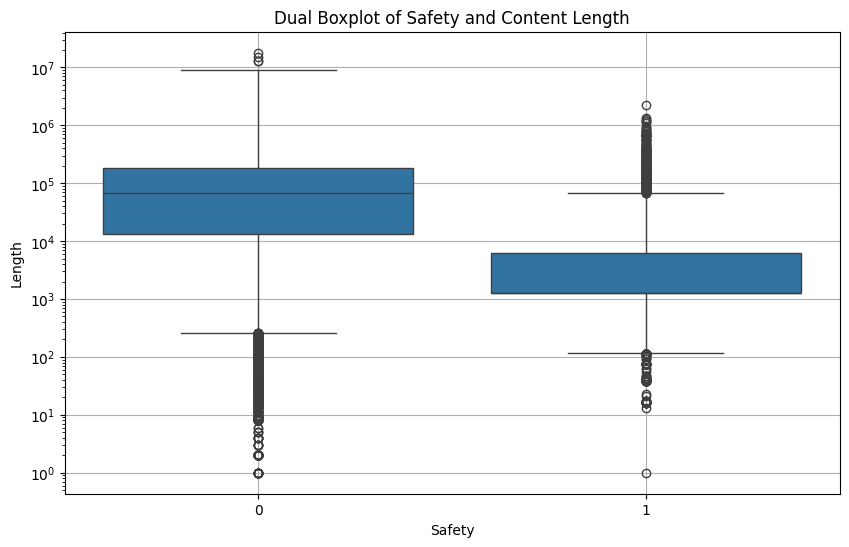

In [22]:
# Boxplot of correlations between length and Safety
plt.figure(figsize=(10, 6))
sns.boxplot(x='safety', y='content_length', data=data,log_scale=True)
plt.xlabel('Safety')
plt.ylabel('Length')
plt.title('Dual Boxplot of Safety and Content Length')
plt.grid(True)
plt.show()

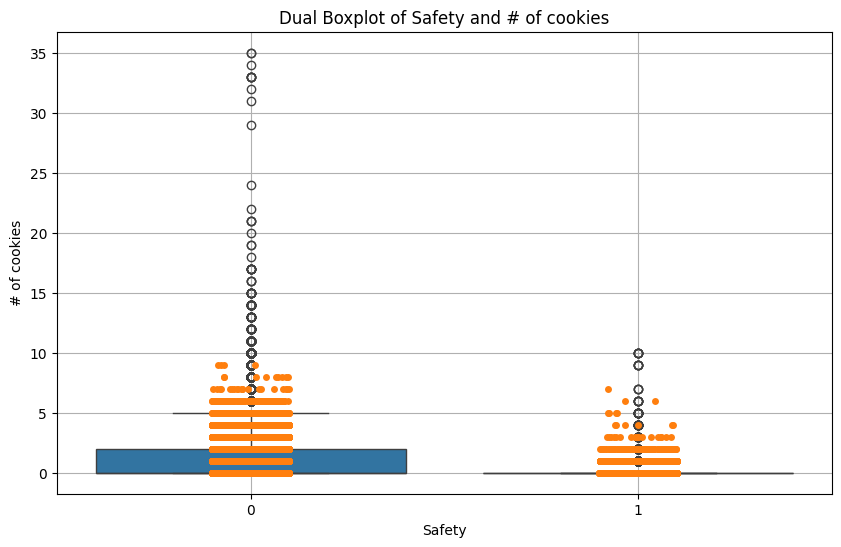

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='safety', y='num_cookies', data=data)
sns.stripplot(x='safety', y='num_redirects', data=data, jitter=True)
plt.xlabel('Safety')
plt.ylabel('# of cookies')
plt.title('Dual Boxplot of Safety and # of cookies')
plt.grid(True)
plt.show()

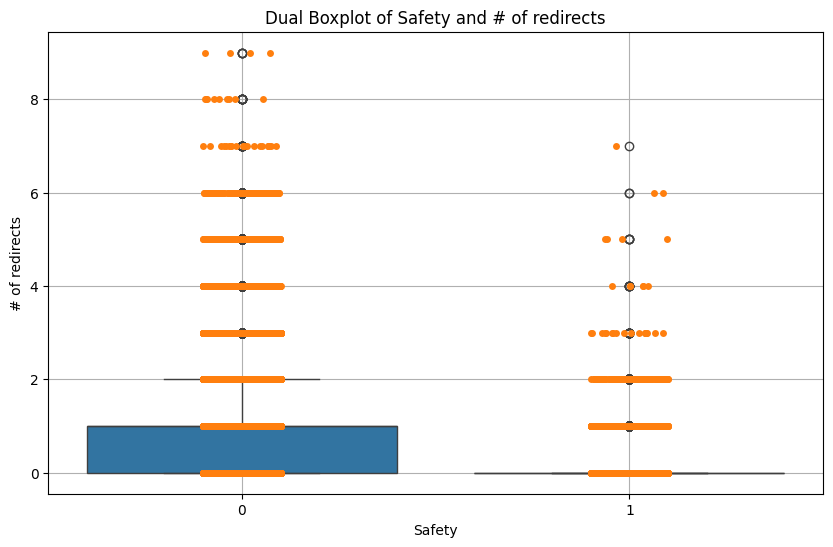

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='safety', y='num_redirects', data=data)
sns.stripplot(x='safety', y='num_redirects', data=data, jitter=True)
plt.xlabel('Safety')
plt.ylabel('# of redirects')
plt.title('Dual Boxplot of Safety and # of redirects')
plt.grid(True)
plt.show()